In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import molsysmt as msm
from molsysmt import pyunitwizard as puw
import omembrane as omem
import openmm as mm
from openmm import unit as u
import numpy as np
import math
from matplotlib import pyplot as plt
from tqdm import tqdm

In [3]:
n_popc_up = 100
n_popc_low = 100

upper_composition={'POPC':n_popc_up}
lower_composition={'POPC':n_popc_low}

In [4]:
length_x, length_y = omem.build.get_membrane_size_from_composition(lower_composition, upper_composition)

In [5]:
print(length_x, length_y)

82.64381404557754 A 82.64381404557754 A


In [6]:
upper_lipid_radius = []
upper_lipid_type = []
n_upper_lipids = 0
    
for name, nn in upper_composition.items():
        
    upper_lipid_type += [name for ii in range(nn)]
    upper_lipid_radius += [omem.lipid.get_radius(name) for ii in range(nn)]
    n_upper_lipids += nn

lower_lipid_radius = []
lower_lipid_type = []
n_lower_lipids = 0
    
for name, nn in lower_composition.items():
        
    lower_lipid_type += [name for ii in range(nn)]
    lower_lipid_radius += [omem.lipid.get_radius(name) for ii in range(nn)]
    n_lower_lipids += nn

In [7]:
upper_positions = omem.build.get_initial_random_seeds_leaf(upper_lipid_radius, length_x, length_y)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.36it/s]


In [8]:
lower_positions = omem.build.get_initial_random_seeds_leaf(lower_lipid_radius, length_x, length_y)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 92.90it/s]


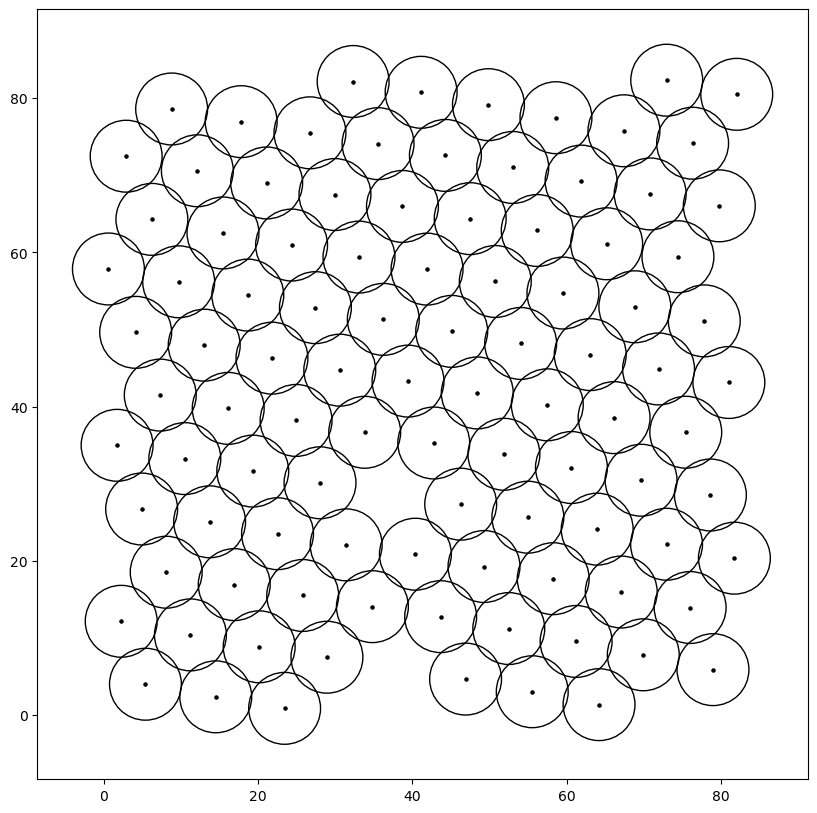

In [9]:
plt.rcParams["figure.figsize"] = (10,10)

ax=plt.gca()
for ii in range(n_upper_lipids):
    ax.add_patch(plt.Circle(10.0*upper_positions[ii,:]._value, radius= upper_lipid_radius[ii]._value, color='k', fill=False))

plt.scatter(10.0*upper_positions[:,0]._value, 10.0*upper_positions[:,1]._value, s=5, c='k')

plt.axis('scaled')

plt.show()

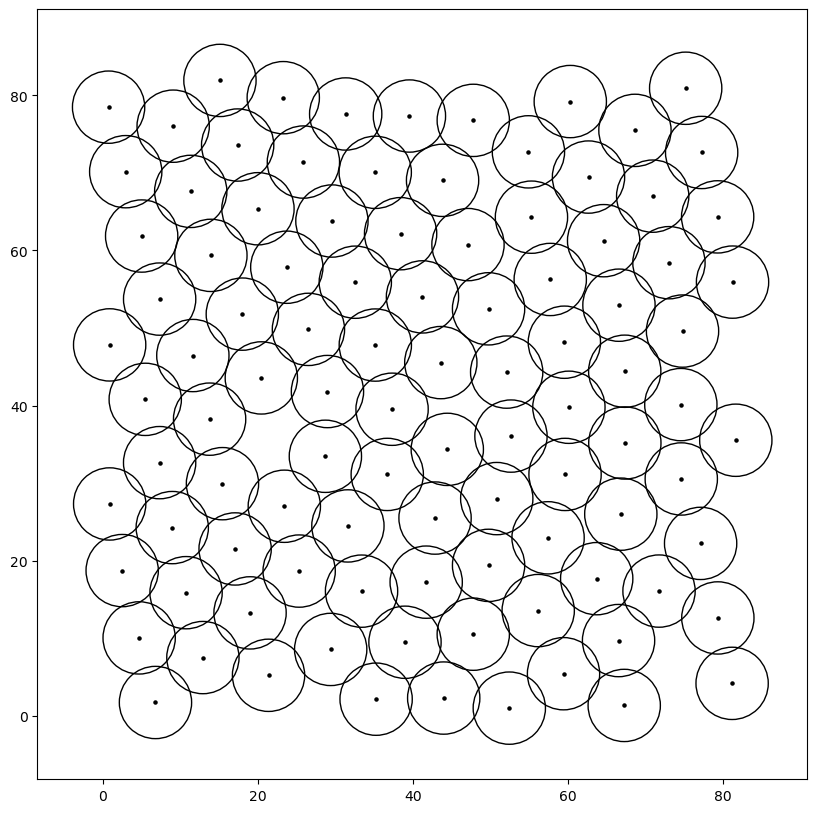

In [10]:
plt.rcParams["figure.figsize"] = (10,10)

ax=plt.gca()
for ii in range(n_lower_lipids):
    ax.add_patch(plt.Circle(10.0*lower_positions[ii,:]._value, radius= lower_lipid_radius[ii]._value, color='k', fill=False))
    
plt.scatter(10.0*lower_positions[:,0]._value, 10.0*lower_positions[:,1]._value, s=5, c='k')

plt.axis('scaled')

plt.show()

In [11]:
## Upper leaflet

lipids = omem.lipid.get_random_lipid('POPC', n_popc_up)

for ii in tqdm(range(n_popc_up)):
    lipid = lipids[ii]
    position = upper_positions[ii]
    msm.structure.translate(lipid, translation=position, in_place=True)

upper_leaflet = msm.merge(lipids)
msm.build.define_new_chain(upper_leaflet, chain_name='U')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.38it/s]


In [12]:
#msm.view(upper_leaflet)

In [13]:
## Lower leaflet

lipids = omem.lipid.get_random_lipid('POPC', n_popc_low)

for ii in tqdm(range(n_popc_low)):
    lipid = lipids[ii]
    position = lower_positions[ii]
    msm.structure.translate(lipid, translation=position, in_place=True)
    
lower_leaflet = msm.merge(lipids)
msm.structure.flip(lower_leaflet, in_place=True)
msm.build.define_new_chain(lower_leaflet, chain_name='L')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.33it/s]


In [14]:
allowed = 50

bins_edges, frequency = omem.analysis.get_lineal_density(upper_leaflet, selection = 'all', axis = [0,0,1],
                                                       bin_length = '0.1 nm', frequency=True)

atoms_in = 0
for inf_lim, n_atoms in zip(bins_edges[:-1], frequency):
    atoms_in += n_atoms
    if atoms_in>allowed:
        break

translation = puw.quantity(np.zeros((3)), 'nm')
translation[2] = -inf_lim

print(inf_lim, atoms_in)

msm.structure.translate(upper_leaflet, translation=translation, in_place=True)

bins_edges, frequency = omem.analysis.get_lineal_density(lower_leaflet, selection = 'all', axis = [0,0,1],
                                                       bin_length = '0.1 nm', frequency=True)
atoms_in = 0
for inf_sup, n_atoms in zip(reversed(bins_edges[1:]), reversed(frequency)):
    atoms_in += n_atoms
    if atoms_in>allowed:
        break

translation[2] = -inf_sup

print(inf_sup, atoms_in)

msm.structure.translate(lower_leaflet, translation=translation, in_place=True)

-2.189223896390993 nanometer 83.0
2.2115493934883492 nanometer 53.0


In [15]:
membrane = msm.merge([upper_leaflet, lower_leaflet])

In [16]:
#msm.view(membrane)

In [17]:
bins_edges, density_P = omem.analysis.get_lineal_density(membrane, selection = 'atom_name == "P"', axis = [0,0,1],
                                                       bins = 80, range="[-3.5, 3.5] nm")

bins_edges, density_Any = omem.analysis.get_lineal_density(membrane, selection='all', axis = [0,0,1],
                                                       bins = 80, range="[-3.5, 3.5] nm")

/home/diego/Myopt/miniconda3/envs/OMembrane@uibcdf_3.10/lib/python3.10/site-packages/matplotlib/cbook.py:1345: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


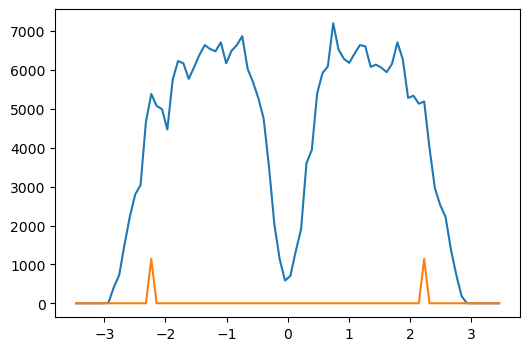

In [18]:
plt.rcParams["figure.figsize"] = (6,4)
plt.plot((bins_edges[1:]+bins_edges[:-1])/2, density_Any)
plt.plot((bins_edges[1:]+bins_edges[:-1])/2, density_P)
plt.show()

In [19]:
clearance = puw.quantity(3, 'nm')

In [20]:
water_tile = msm.convert('../omembrane/data/water/spc216.gro')
box_tile = msm.get(water_tile, box=True)[0]

tiles = []

box = puw.quantity([[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]], 'nm')
box[0,0] = puw.convert(length_x, to_unit='nm', to_form='pint')
box[1,1] = puw.convert(length_y, to_unit='nm', to_form='pint')
box[2,2] = clearance

delta_x_tiles = box_tile[0,0]
n_x_tiles = np.ceil(box[0,0]/delta_x_tiles)
n_x_tiles = int(n_x_tiles)
print(n_x_tiles, delta_x_tiles, box[0,0])

delta_y_tiles = box_tile[1,1]
n_y_tiles = np.ceil(box[1,1]/delta_y_tiles)
n_y_tiles = int(n_y_tiles)
print(n_y_tiles, delta_y_tiles, box[1,1])

delta_z_tiles = box_tile[2,2]
n_z_tiles = np.ceil(box[2,2]/delta_z_tiles)
n_z_tiles = int(n_z_tiles)
print(n_z_tiles, delta_z_tiles, box[2,2])

tiles = []

for ii in tqdm(range(n_x_tiles)):
    for jj in range(n_y_tiles):
        for kk in range(n_z_tiles):

            translation = puw.concatenate([(ii+0.5)*delta_x_tiles, (jj+0.5)*delta_y_tiles, (kk+0.5)*delta_z_tiles])
            tile = msm.structure.translate(water_tile, translation=translation)
            tiles.append(tile)

water_semibox = msm.merge(tiles)

5 1.86206 nanometer 8.264381404557753 nanometer
5 1.86206 nanometer 8.264381404557753 nanometer
2 1.86206 nanometer 3.0 nanometer


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.19s/it]


In [21]:
water_semibox.add_missing_bonds()

In [22]:
water_semibox.rebuild_components()
water_semibox.rebuild_molecules()
water_semibox.rebuild_entities()

In [ ]:
msm.view(water_semibox, with_water_as='licorice')

In [23]:
msm.info(water_semibox)

form,n_atoms,n_groups,n_components,n_chains,n_molecules,n_entities,n_waters,n_structures
molsysmt.MolSys,32400,10800,10802,50,10802,2,10800,1


In [ ]:
group_indices, coordinates = msm.get(water_semibox, element='atom', selection='atom_type=="O"',
                             group_index=True, coordinates=True)

In [ ]:
mask = (coordinates[0,:,0]>box[0,0]) | (coordinates[0,:,1]>box[1,1])| (coordinates[0,:,2]>box[2,2])
group_indices = np.array(group_indices)[mask]

In [ ]:
water_semibox = msm.remove(water_semibox, selection='group_index == @group_indices')

In [ ]:
msm.info(water_semibox)

In [ ]:
water_semibox_upper = water_semibox
water_semibox_lower = msm.copy(water_semibox)
msm.structure.flip(water_semibox_lower, in_place=True)

In [ ]:
coordinates_Ps = msm.get(membrane, selection='atom_name=="P"', coordinates=True)
mask = coordinates_Ps[0,:,2]>0.0*puw.unit('nm')
coordinates_Ps_upper = coordinates_Ps[0,mask,2].mean()
coordinates_Ps_lower = coordinates_Ps[0,~mask,2].mean()

In [ ]:
coordinates_Ps_upper

In [ ]:
coordinates_Ps_lower

In [ ]:
translation = [0.0, 0.0, 0.0]*puw.unit('nm')
v_shift = 0.2*puw.unit('nm')
translation[2] = coordinates_Ps_upper + v_shift
msm.structure.translate(water_semibox_upper, translation=translation, in_place=True)
translation[2] = coordinates_Ps_lower - v_shift
msm.structure.translate(water_semibox_lower, translation=translation, in_place=True)

In [ ]:
top_z = coordinates_Ps_upper + clearance + v_shift
bottom_z = coordinates_Ps_lower - clearance - v_shift
length_z = top_z - bottom_z

In [ ]:
length_z

In [ ]:
water = msm.merge([water_semibox_lower, water_semibox_upper])
msm.build.define_new_chain(water, selection='all', id='W')

In [ ]:
molecular_system = msm.merge([membrane, water])

In [ ]:
msm.info(molecular_system)

In [ ]:
box = puw.quantity(np.zeros((3,3)), 'nm')

box[0,0] = puw.convert(length_x, 'nm', to_form='pint')
box[1,1] = puw.convert(length_y, 'nm', to_form='pint')
box[2,2] = length_z

msm.set(molecular_system, box=box)

In [ ]:
selection_not_water = msm.select(molecular_system, selection='molecule_type!="water" and atom_type!="H"')
selection_water = msm.select(molecular_system, selection='molecule_type=="water" and atom_type=="H"')
neighs, dists = msm.structure.get_neighbors(molecular_system, selection=selection_not_water, selection_2=selection_water,
                           threshold='3.5 angstroms', pbc=True)
aux_list = np.unique(np.concatenate(neighs[0]))
oxygens_to_be_removed = selection_water[aux_list]
groups_to_be_removed = msm.get(molecular_system, selection=oxygens_to_be_removed, group_index=True)
print(len(groups_to_be_removed))
molecular_system = msm.remove(molecular_system, selection='group_index==@groups_to_be_removed')

In [ ]:
msm.info(molecular_system)

In [ ]:
msm.view(molecular_system, with_water_as='licorice')

In [ ]:
msm.convert(molecular_system, 'memb_popc_100_stage_1.msmpk')